In [ ]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import stats
from scipy.interpolate import interp1d
from Image_class import ProcessedImage

class BG_Calibrater:      #medianフィルター未実装
    '''
    input: 2-D array(original AFM image)
    output: ProcessedImage class which has calibrated_image
    -------------------work flow-------------------
    decide the threshold for outlier(low:depression of mica, high:CNF)
    バックグラウンドのみ抽出
    取り除いた外れ値の部分を線形補完
    savgolフィルターによる近似曲線抽出
    元データ-近似曲線でベースラインの補正
    必要であればメディアンフィルターの適用
    補正後の画像を属性に持つProcessedImageクラスのインスタンスを出力する

    -------------------Parameter-------------------
    savgol_window
    savgol_polyorder
    apply_median

    '''
    def __init__(self, savgol_window=31, savgol_polyorder=2, apply_median=True):
        self.savgol_window = savgol_window
        self.savgol_polyorder = savgol_polyorder
        self.apply_median = apply_median

    def __call__(self, original_image):
        '''
        original_image is 2D array 
        '''
        output_instance = ProcessedImage(original_image)
        
        thresholds_low, thresholds_high = self._get_thresholds(original_image)
        #以下のfilterは、ただ中間結果を保持しているだけなので、改善できる気がする
        #thresholds, filterはsplineのための中間結果だし、splineはsmoothingのための中間結果。
        '''
        三層構造に改善できそう？
        smoothing:
            original - background_smoothed
            background_smoothed:
                
                        

        '''
        background_filter = self._get_background_filter(original_image, thresholds_low, thresholds_high)
        background_splined = self._get_splined_background(original_image, background_filter)
        background_smoothed = self._savgol_smoothing(background_splined, self.savgol_window, self.savgol_polyorder)
        calibrated_image = original_image - background_smoothed
        if self.apply_median == True:
            calibrated_image = cv2.medianBlur(calibrated_image.astype(np.float32), ksize=3)
            
        output_instance.calibrated_image = calibrated_image
        return output_instance


    @staticmethod
    def _get_thresholds(image):      #各行の外れ値の閾値を取得（2次元array）
        weight_q1 = stats.scoreatpercentile(image, 25, axis=1).reshape((image.shape[0], 1))
        weight_q3 = stats.scoreatpercentile(image, 75, axis=1).reshape((image.shape[0], 1))
        weight_iqr = weight_q3 - weight_q1
        thresholds_low = weight_q1 - (weight_iqr) * 1.5
        thresholds_high =  weight_q3 + (weight_iqr)* 0          #*0であってる？
        return thresholds_low, thresholds_high
    
    @staticmethod
    def _get_background_filter(image, thresholds_low, thresholds_high):
        '''
         get the filter to remove the outlier pixel(CNF and depression) from AFM image
        '''
        background_filter = (image > thresholds_low) & (image < thresholds_high)
        background_filter[:,0] = True
        background_filter[:,-1] = True    #画像の端をTrueにしておかないと次の補完でエラーになる
        return background_filter

    @staticmethod
    def _get_splined_background(original_image, background_filter):   #欠損しているバックグラウンドの補完
        splined_bg = np.empty(original_image.shape)
        n_row, n_column = original_image.shape
        for row in range(n_row):
            filter_row = background_filter[row]
            background_x, *_ = np.where(filter_row)
            background_height = original_image[row][filter_row]
            f = interp1d(background_x, background_height)
            x = np.arange(n_column)  #画像の横一列のピクセル番号（0～1023）
            splined_bg[row] = f(x)
        return  splined_bg  

    @staticmethod
    def _savgol_smoothing(background_splined, window_length, polyorder):
        def savgol(row, wl=window_length, po=polyorder):
            return savgol_filter(row, wl, po)
        bg_smoothed = np.apply_along_axis(savgol, 1, background_splined)
        return bg_smoothed
        
        

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny
from skimage.filters import threshold_local
from skimage.morphology import  binary_opening, binary_closing, binary_erosion, binary_dilation
from skimage.transform import probabilistic_hough_line

class Segmentater:    #クッソ遅い（どこが遅いかは調べてないが、多分ラベリングとハフ変換）。本当にハフ変換必要なのか...
    def __init__(self,  area_min=200, low_threshold, global_threshold=0.3, wsize_localbin=17, H_length=12, H_Sratio=0.3):
#         self.image = calibrated_image
        self.global_threshold = global_threshold
        self.wsize_localbin = wsize_localbin
        self.area_min = area_min
        self.low_threshold = low_threshold
        self.H_length = H_length
        self.H_Sratio = H_Sratio
        
        self.binary_image = None
        self.no_linear = None

    def __call__(self, calibrated_image):
        '''
        -------------input-------------------
        calibrated_image:
            BG_calibrater で出力したProcessedImageクラス
        -------------output-------------------
        
        -------------processing flow-----------------
        1. binary_global
        2. binary_local
        3. 1 & 2     ここまでひとまとめにで良さそう（binaryzation）
        4. remove small component     超ぐちゃぐちゃだけど、もっとシンプルにならないか？後で最大高さ1.5でふるいにかけるし
            4.1 smoothing by median filter  ぶっちゃけこれ必要か？とりあえず無視
            4.2 labeling
            4.3 remove small area under area_min これ必要か？4.5のやつをここでやれば良い気もする
            4.4 hough transformation　計算量多いので、省略できないか？
            4.5 erosion and remove small components under area_min2
            4.6 dilation
            4.7 closing

        '''
        binary_image = self._binaryzation(calibrated_image.calibrated_image,
                                          self.global_threshold,
                                          self.wsize_localbin)
        no_small_binary_image = self._remove_connecting_fragments(binary_image,
                                                                  self.area_min)
        no_small_binary_image = self._remove_nonlinear_objects(no_small_binary_image,
                                                               self.H_length,
                                                               self.H_Sratio)
#         no_small_binary_image = self._remove_small(binary_image, self.area_min)
        calibrated_image.binarized_image = no_small_binary_image
        return calibrated_image

    @staticmethod
    def _binaryzation(image, global_threshold, wsize_localbin):
        binary_global = image > global_threshold
        local_threshold = threshold_local(image, wsize_localbin)
        binary_local = image > local_threshold
        binary_final = binary_global & binary_local    #データ型はbooleanのままか、int8に直すか未定
        return binary_final

    @staticmethod
    #so heavy process
    def _remove_small(binary_image, area_min):
        out_binary_image = binary_image.copy()
        n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(binary_image), 8)
        for i in range(n_labels-1):
            *_, area = stats[i]
            if area <= area_min:
                out_binary_image[label_image==i] = 0    #入力のbinary_image自体を書き換えて出力
        return out_binary_image
    
    @staticmethod
    #オブジェクトが多すぎて、ラベルが0～255に収まりきらないかもしれん
    def _remove_connecting_fragments(binary_image, area_min):
        out_binary_image = binary_image.copy()
        out_binary_image = binary_erosion(out_binary_image)
        n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(binary_image), 8)
        for i in range(n_labels-1):
            *_, area = stats[i]
            if area <= area_min:
                out_binary_image[label_image==i] = 0    #入力のbinary_image自体を書き換えて出力
        out_binary_image = binary_dilation(out_binary_image)
        return out_binary_image
            
    @staticmethod
    def _remove_nonlinear_objects(binary_image, H_length, H_Sratio, linegap=1):
        out_binary_image = binary_image.copy()
        n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(out_binary_image), 8)
        for i in range(n_labels-1):
            left, top, width, height, area = stats[i]
            target = out_binary_image[top:top+height, left:left+width]      #インデックスの指定あってるか自信ない
            target_edge = canny(target, sigma=0,
                                low_threshold=0,
                                high_threshold=1)
            hough_lines = probabilistic_hough_line(target_edge,
                                                   line_length=H_length,
                                                   line_gap=linegap)
            line_lengths = [np.linalg.norm(np.array(start) - np.array(end)) for (start, end) in hough_lines]   #あってるか自信ない
            total_length = sum(line_lengths)
            S_ratio = total_length / np.sum(target_edge)
            
            if S_ratio < H_Sratio and np.sum(target) < 500:  #keep big object larger than 500
                out_binary_image[label_image==i] = 0
            
            return out_binary_image
    
    @staticmethod
    def remove_low_component(height_image, binary_image):
        n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(out_binary_image), 8)
        pass

In [2]:
from skimage.morphology import skeletonize,thin
import imptools

class Skeltonizer:
    def __init__(self, bp_height=5, branch_length=8, image_size=1024):
        self.bp_height = bp_height
        self.branch_length = branch_length
        self.image_size = image_size
        #インスタンス変数のメリットは、複数回利用するような変数を保持できる事？だとしたら今のインスタンス変数はあまり意味がない
        #内部処理用の変数として、coor_low_bps, coor_close_eps, branches_imageなどは保存していた方が、
        #説明用のグラフ作ったりバグ修正に便利かも
        self._coor_low_bps = None
        self._coor_close_eps = None
        self._branches_image = None
        
        
    def __call__(self, image):
        '''
        -------------input-------------------
        image:
            BG_calibrater -> Segmentater で出力したProcessedImageインスタンス
        -------------output-------------------
        入力のProcessedImageインスタンスの属性に細線化画像（枝除去済み）を追加する
        
        -------------processing flow-----------------
        extract initial center line (with branch)
        remove branch:
            init_skeltone - branch_image
            pick up low branch point:
            
            prune short branch derive from low branch point:
        '''
        
        init_skeltone_image = thin(image.binarized_image)
        nobranch_skeltone_image = self.prune_branches(image.calibrated_image, init_skeltone_image)
        image.skeltone_image = nobranch_skeltone_image
        
        return image
    
    def prune_branches(self, calibrated_image, init_skeltone_image):
        branches_image = self.calc_branches_image(calibrated_image, init_skeltone_image)        
        return init_skeltone_image - branches_image
        
        
    def calc_branches_image(self, calibrated_image, init_skeltone_image):
#         coor_low_bps = np.where(imptools.branchedPoints(init_skeltone_image))
        branches_image = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        coor_low_bps = self.get_low_bp_coor(calibrated_image,
                                            init_skeltone_image,
                                            self.bp_height)
        coor_close_eps = self.get_close_eps(init_skeltone_image, #next process (track_branches) may be heavy 
                                            coor_low_bps,
                                            self.branch_length)
        coor_branch = self.track_branches(init_skeltone_image,
                                          coor_close_eps,
                                          coor_low_bps,
                                          self.branch_length)
#         print(coor_branch)
        branches_image[coor_branch] = 1
        return branches_image
    
    @staticmethod
    def get_low_bp_coor(calibrated_image, init_skeltone_image, bp_height):
        all_bps = imptools.branchedPoints(init_skeltone_image)
        return np.where(all_bps & (calibrated_image < bp_height))
    
    
    def get_close_eps(self, init_skeltone_image, coor_low_bps, branch_length): #eps eny close than branch_length
        close_eps = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        
        all_eps_coorx, all_eps_coory = np.where(imptools.endPoints(init_skeltone_image))
        _low_bps_image = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        _low_bps_image[coor_low_bps] = 1
        for x, y in zip(all_eps_coorx, all_eps_coory):
            window = _low_bps_image[x-branch_length:x+branch_length,
                                    y-branch_length:y+branch_length]
            if window.any():  #window中に一つでもlow_bpが入っているならTrue
                close_eps[x, y] = 1
        
        coor_close_eps = np.where(close_eps)
        return coor_close_eps
        
    
    def track_branches(self, init_skeltone_image, coor_close_ep, coor_low_bps, branch_length):
        branches_coor_x = []
        branches_coor_y = []
        image_for_tracking = init_skeltone_image.copy()
        
        image_low_bps = np.zeros((self.image_size, self.image_size), dtype=bool)
        image_low_bps[coor_low_bps] = True  #low_bpに目印として2を設定
        #epからトラック開始。low_bpにぶつかったら終了
        starts_x, starts_y = coor_close_ep
        for start_x, start_y in zip(starts_x, starts_y):
            #tracking_area中の座標からimage_for_tracking中の座標に変換するため、x,yを最後に足すの忘れずに！
            tracking_area = image_for_tracking[start_x - branch_length : start_x + branch_length, 
                                               start_y - branch_length : start_y + branch_length]
            
            image_for_bp_detection = image_low_bps[start_x - branch_length : start_x + branch_length, 
                                                   start_y - branch_length : start_y + branch_length]
            
            x, y = branch_length, branch_length  #トラッキング開始点となるtracking_areaの中心点の位置
            
            xtrack = [x+start_x-branch_length]  #各枝ごとの結果格納用(初期位置であるtracking_areaの中心は最初に追加)
            ytrack = [y+start_y-branch_length]
            
            for i in range(branch_length):
                tracking_area[x,y] = 0 #現在の注目画素の値を0に更新
                #移動方向の探索
                window = tracking_area[x-1:x+2,y-1:y+2]
                if (window == 0).all():   #windowsの中身が全て0(つまり別のepにたどり着いた)なら停止
                    break
                elif image_for_bp_detection[x-1:x+2,y-1:y+2].any():  #low_branchの手前になったら消去
                    break
                direction = np.where(window != 0)
                direction = [a-1 for a in direction]
                x += int(direction[0]); y += int(direction[1])
                xtrack.append(x+start_x-branch_length)
                ytrack.append(y+start_y-branch_length)
                 
            branches_coor_x += xtrack
            branches_coor_y += ytrack
            
        branches_coor_x = np.asarray(branches_coor_x); branches_coor_y = np.asarray(branches_coor_y)
        #各tracking_areaのままの座標なので、skeltone_image用の座標に変換する
#         print(branches_coor_x)
#         branches_coor_x += starts_x.reshape(len(branches_coor_x), 1)
#         branches_coor_y += starts_y.reshape(len(branches_coor_y), 1)
        return branches_coor_x, branches_coor_y

In [3]:
%matplotlib inline

(1024, 1024)
(1841,)


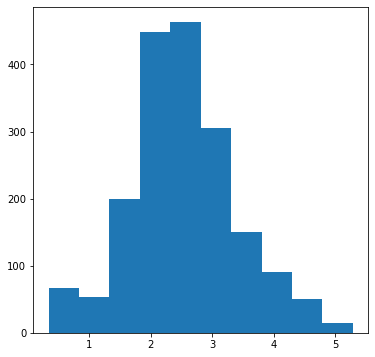

(1024, 1024)
(3228,)


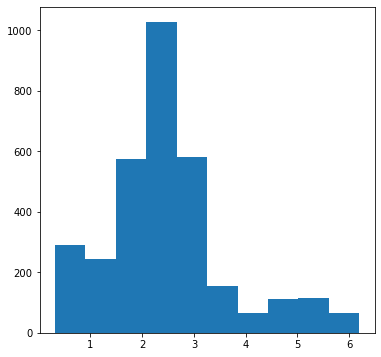

(1024, 1024)
(2678,)


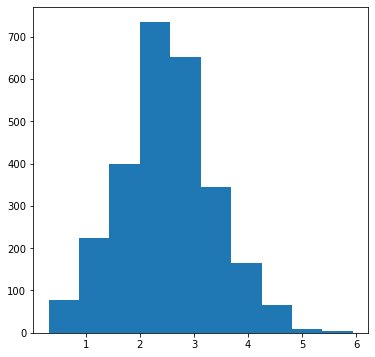

(1024, 1024)
(1049,)


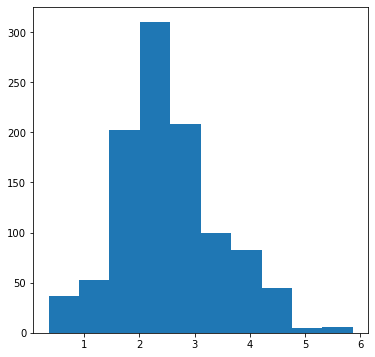

(1024, 1024)
(3201,)


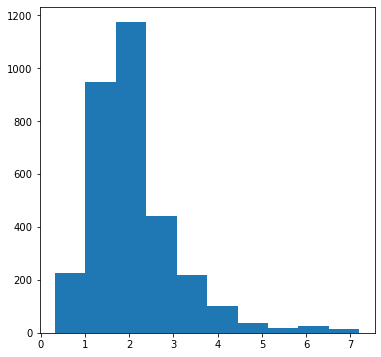

(1024, 1024)
(1638,)


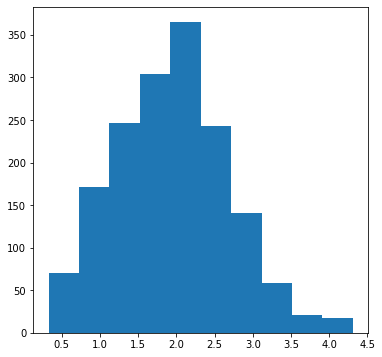

(1024, 1024)
(2260,)


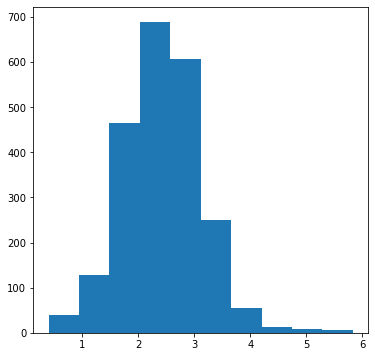

(1024, 1024)
(2010,)


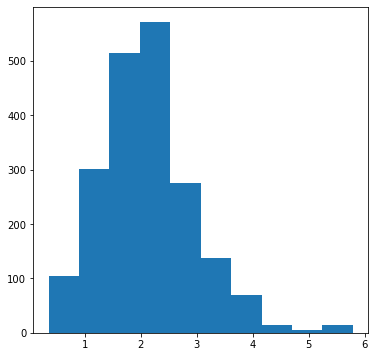

(1024, 1024)
(1542,)


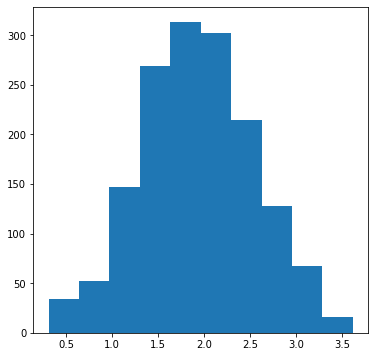

(1024, 1024)
(5075,)


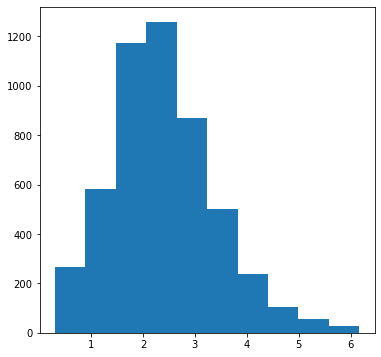

(1024, 1024)
(12143,)


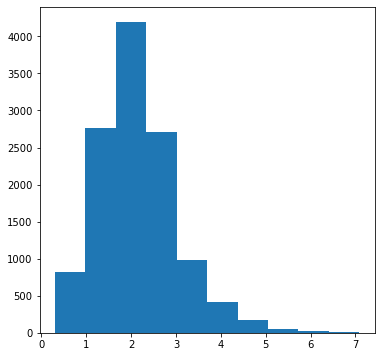

In [4]:
from pathlib import Path
# from BG_Calibrater import BG_Calibrater
# from Image_class import Image_class

filepath = Path("../data/4pass_data_ver.2") 
flist = list(filepath.glob('*.txt'))
flist.sort()

calibrater = BG_Calibrater()
segmentater = Segmentater()
skeltonizer = Skeltonizer()

for file in flist:
    AFM_image = np.loadtxt(file, skiprows=1).reshape(1024, 1024)
    image = calibrater(AFM_image)
    image = segmentater(image)
    image = skeltonizer(image)
    
    height = image.heights_skeltone()
    calibrated = image.calibrated_image
    print(calibrated.shape)
    print(height.shape)
    
    
#     bps = imptools.branchedPoints(image.skeltone_image)
#     coor_bps = np.where(bps)
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.hist(height)
#     ax.imshow(image.calibrated_image, cmap='afmhot', vmin=-0.5, vmax=4.5)
#     ax.imshow(image.binarized_image, cmap='gray')
#     ax.imshow(image.skeltone_image, cmap='gray')
#     ax.scatter(coor_bps[1],coor_bps[0], color='green')
    plt.show()

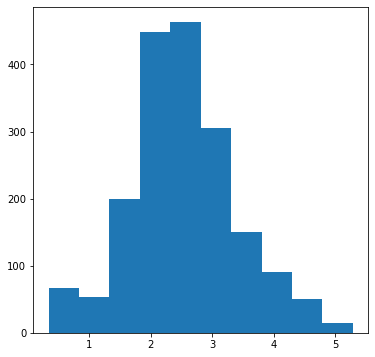

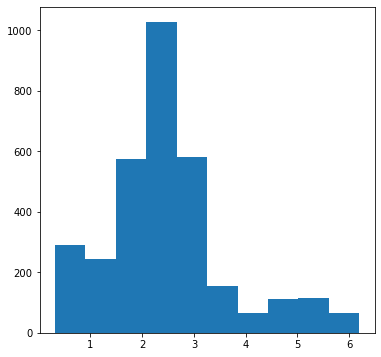

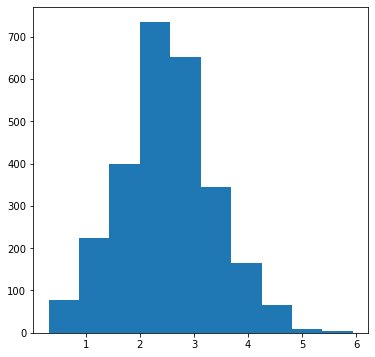

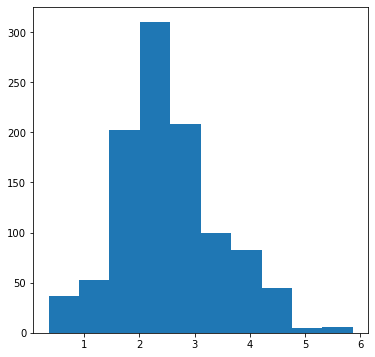

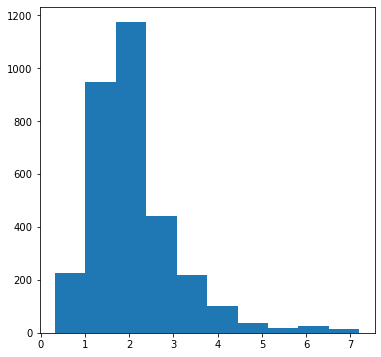

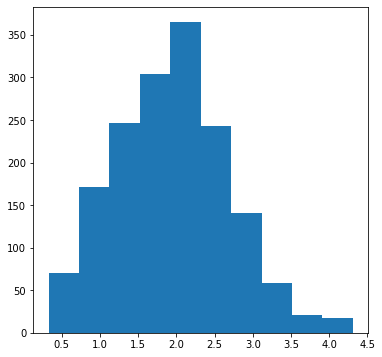

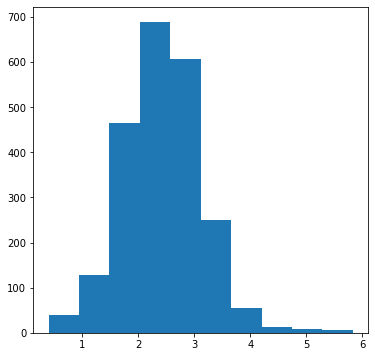

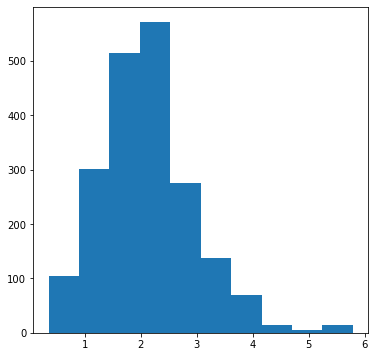

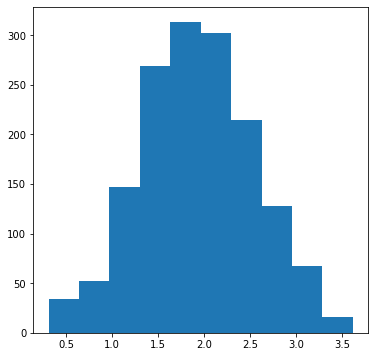

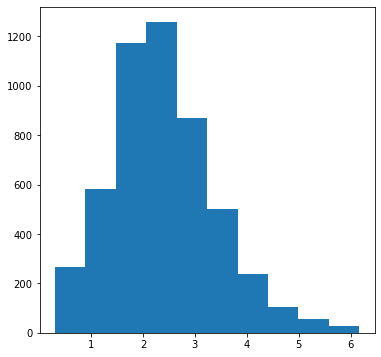

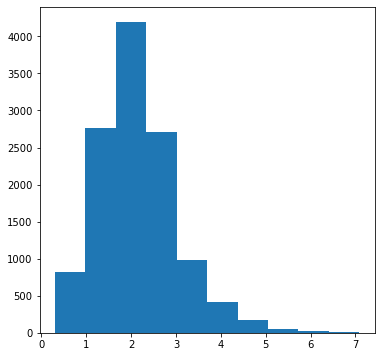

In [6]:
from pathlib import Path

filepath = Path("../data/4pass_data_ver.2") 
flist = list(filepath.glob('*.txt'))
flist.sort()

calibrater = BG_Calibrater()
segmentater = Segmentater()
skeltonizer = Skeltonizer()

for file in flist:
    AFM_image = np.loadtxt(file, skiprows=1).reshape(1024, 1024)
    image = calibrater(AFM_image)
    image = segmentater(image)
    image = skeltonizer(image)
    
    height = image.heights_skeltone()

    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.hist(height)
    plt.show()